In [241]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn import metrics, datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss, roc_auc_score
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

plt.rc("font", size=14)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.info()
print(train.shape)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 66.2+ KB
(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Missing data

In [242]:
# train[pd.isnull(train.Survived)].head()
# train[pd.isnull(train.Embarked)]
print(train.isnull().sum().sort_values(ascending = False))
print(pd.unique(train.Embarked))
# print(pd.unique(train.Cabin))
print(train["Embarked"].mode())

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64
['S' 'C' 'Q' nan]
0    S
dtype: object


**Data Visualization**

In [243]:
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

#calculate percentages of CabinBool vs. survived
print("Percentage of CabinBool = 1 who survived:", train["Survived"][train["CabinBool"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of CabinBool = 0 who survived:", train["Survived"][train["CabinBool"] == 0].value_counts(normalize = True)[1]*100)
# #draw a bar plot of CabinBool vs. survival
print(train["CabinBool"].dtype)
# sns.barplot(x="CabinBool", y="Survived", data=train)
# plt.show()

Percentage of CabinBool = 1 who survived: 66.66666666666666
Percentage of CabinBool = 0 who survived: 29.985443959243085
int32


People with a recorded Cabin number are, in fact, more likely to survive. (66.6% vs 29.9%)

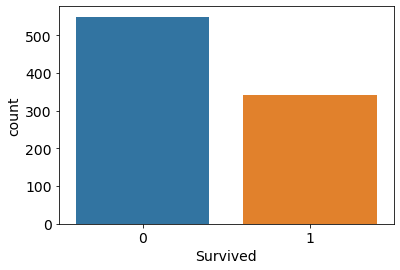

In [244]:
# train_data.groupby('NameTitle')['PassengerId'].count()
train['Survived'].value_counts()
sns.countplot(x = 'Survived', data = train)

In [252]:
count_yes = len(train[train['Survived'] == 1])
count_no = len(train[train['Survived']== 0])
pct_of_no_sub = count_no/(count_no+count_yes)
print("percentage of no subscription is", pct_of_no_sub*100)
pct_of_sub = count_yes/(count_no+count_yes)
print("percentage of subscription", pct_of_sub*100)

percentage of no subscription is 61.61616161616161
percentage of subscription 38.38383838383838


In [246]:
train.groupby('Survived').mean()

,PassengerId,Pclass,Sex,SibSp,Parch,Fare,Embarked,CabinBool,NameTitle,AgeGroup
Survived,,,,,,,,,,
0,447.016393,2.531876,0.852459,0.553734,0.329690,22.117887,1.641166,0.123862,1.939891,4.783242
1,444.368421,1.950292,0.318713,0.473684,0.464912,48.395408,1.368421,0.397661,1.833333,4.500000


In [247]:
train.groupby('Embarked').mean()


,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,CabinBool,NameTitle,AgeGroup
Embarked,,,,,,,,,,
0,445.357143,0.553571,1.886905,0.565476,0.386905,0.363095,59.954144,0.410714,1.970238,4.702381
1,417.896104,0.389610,2.909091,0.532468,0.428571,0.168831,13.276030,0.051948,1.558442,4.766234
2,449.517028,0.339009,2.346749,0.682663,0.569659,0.411765,27.243651,0.202786,1.921053,4.656347


In [248]:
train.groupby('Sex').mean()



,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Embarked,CabinBool,NameTitle,AgeGroup
Sex,,,,,,,,,,
0,431.028662,0.742038,2.159236,0.694268,0.649682,44.479818,1.420382,0.308917,1.837580,4.484076
1,454.147314,0.188908,2.389948,0.429809,0.235702,25.523893,1.599653,0.185442,1.932409,4.778163


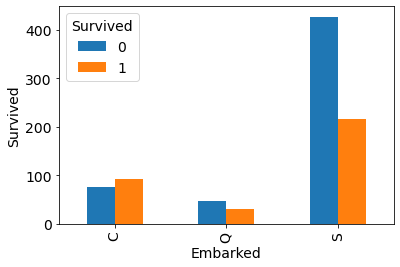

In [253]:
pd.crosstab(train.Embarked,train.Survived).plot(kind='bar')
plt.title('')
plt.xlabel('Embarked')
plt.ylabel('Survived')
plt.savefig('Survived_Embarked')

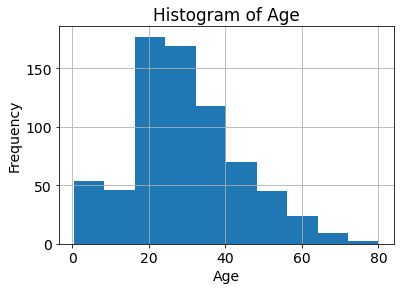

In [254]:
train.Age.hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

In [255]:
# pd.crosstab(train_data.Age,train_data.Survived).plot(kind='bar')
# plt.title('')
# plt.xlabel('Age')
# plt.ylabel('Survived')
# plt.savefig('Survived_AgeGroup')

In [256]:
# pd.crosstab(train.Fare,train.Survived).plot(kind='bar')
# plt.title('')
# plt.xlabel('Fare')
# plt.ylabel('Survived')
# plt.savefig('Survived_FareGroup')

In [257]:
# train['AgeGroup'].dtype
# X = train.loc[:, train.columns != 'Survived']
# Y = train.loc[:, train.columns == 'Survived']
# model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
# model.fit(X, Y)

**Data Preparartion**

In [258]:
train_data = train.copy()
train_data["Embarked"] = train_data["Embarked"].fillna(train["Embarked"].mode()[0], inplace = False)
train_data["Age"] = train_data["Age"].fillna(train["Age"].mean(), inplace = False)
# train.Cabin.fillna("Unknown")
train_data['Age'] = pd.to_numeric(train_data['Age'])

# print(train_data["NameTitle"].value_counts())
train_data["NameTitle"] = train_data["Name"].str.split(", ", expand = True)[1].str.split(". ", expand = True)[0]
train_data['NameTitle'] = train_data['NameTitle'].replace(['Lady','Capt','Col','Don','Dr','Major','Rev','Jonkheer','Dona'], 'Rare')
train_data['NameTitle'] = train_data['NameTitle'].replace(['Countess','Lady','Sir'], 'Royal')
train_data['NameTitle'] = train_data['NameTitle'].replace('Mlle','Miss')
train_data['NameTitle'] = train_data['NameTitle'].replace('Ms','Miss')
train_data['NameTitle'] = train_data['NameTitle'].replace('Mme','Mrs')

# train_data["AgeGroup"] = ""
# train_data.loc[(train_data["Age"].isnull()), "AgeGroup"] = "Unknown"
# train_data.loc[(train_data["Age"] <= 5), "AgeGroup" ] = "Baby"
# train_data.loc[(train_data["Age"] > 5) & (train_data["Age"] <= 12), "AgeGroup" ] = "Child"
# train_data.loc[(train_data["Age"] > 12) & (train_data["Age"] <= 18), "AgeGroup" ] = "Teenager"
# train_data.loc[(train_data["Age"] > 18) & (train_data["Age"] <= 24), "AgeGroup" ] = "Student"
# train_data.loc[(train_data["Age"] > 24) & (train_data["Age"] <= 35), "AgeGroup" ] = "Young Adult"
# train_data.loc[(train_data["Age"] > 35) & (train_data["Age"] <= 60), "AgeGroup" ] = "Adult"
# train_data.loc[(train_data["Age"] > 60), "AgeGroup" ] = "Senior"

# train.loc[(train["Fare"] < 100) , "FareGroup" ] = "less than 100"
# # train.loc[(train["Fare"] > 20) & (train["Fare"] < 40), "FareGroup"] = " 20-40"
# # train.loc[(train["Fare"] > 40) & (train["Fare"] < 60), "FareGroup"] = "40-60"
# # train.loc[(train["Fare"] > 60) & (train["Fare"] < 80), "FareGroup"] = "60-80"
# # train.loc[(train["Fare"] > 80) & (train["Fare"] < 100), "FareGroup"] = "80-100"
# train.loc[(train["Fare"] > 100) & (train["Fare"] < 150), "FareGroup"] = "100-150"
# train.loc[train["Fare"] > 150, "FareGroup"] = " higher than 150"

# mr_age = train_data[train_data["NameTitle"] == 1]["AgeGroup"].mode() #Young Adult
# miss_age = train_data[train_data["NameTitle"] == 2]["AgeGroup"].mode() #Student
# mrs_age = train_data[train_data["NameTitle"] == 3]["AgeGroup"].mode() #Adult
# master_age = train_data[train_data["NameTitle"] == 4]["AgeGroup"].mode() #Baby
# royal_age = train_data[train_data["NameTitle"] == 5]["AgeGroup"].mode() #Adult
# rare_age = train_data[train_data["NameTitle"] == 6]["AgeGroup"].mode() #Adult
# age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

# for x in range(len(train_data["AgeGroup"])):
#     if train_data["AgeGroup"][x] == "Unknown":
#         train_data["AgeGroup"][x] = age_title_mapping[train_data["NameTitle"][x]]
# age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
# train_data['AgeGroup'] = train_data['AgeGroup'].map(age_mapping)

train_data['NameTitle'] = train_data['NameTitle'].astype(str)
train_data['Embarked'] = train_data['Embarked'].astype(str)
cat_features = [ 'Sex', 'Embarked', 'NameTitle']
encoder = LabelEncoder()
train_data[cat_features] = train_data[cat_features].apply(encoder.fit_transform)
train_data.drop(["Name", "Cabin", "Ticket"], axis = 1, inplace = True)

print(train_data.head())

   PassengerId  Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  \
0            1         0       3    1  22.0      1      0   7.2500         2   
1            2         1       1    0  38.0      1      0  71.2833         0   
2            3         1       3    0  26.0      0      0   7.9250         2   
3            4         1       1    0  35.0      1      0  53.1000         2   
4            5         0       3    1  35.0      0      0   8.0500         2   

   CabinBool  NameTitle  
0          0          2  
1          1          3  
2          0          1  
3          1          3  
4          0          2  


**Test Data**

In [259]:
test_data = test.copy()

test_data["Age"] = test_data["Age"].fillna(test["Age"].mean(), inplace = False)
test_data["Fare"] = test_data["Fare"].fillna(test["Fare"].mode()[0], inplace = False)

test_data["NameTitle"] = test_data["Name"].str.split(", ", expand = True)[1].str.split(". ", expand = True)[0]
test_data['NameTitle'] = test_data['NameTitle'].replace(['Lady','Capt','Col','Don','Dr','Major','Rev','Jonkheer','Dona'], 'Rare')
test_data['NameTitle'] = test_data['NameTitle'].replace(['Countess','Lady','Sir'], 'Royal')
test_data['NameTitle'] = test_data['NameTitle'].replace('Mlle','Miss')
test_data['NameTitle'] = test_data['NameTitle'].replace('Ms','Miss')
test_data['NameTitle'] = test_data['NameTitle'].replace('Mme','Mrs')

# test_data["AgeGroup"] = ""
# test_data.loc[(test_data["Age"].isnull()), "AgeGroup"] = "Unknown"
# test_data.loc[(test_data["Age"] <= 5), "AgeGroup" ] = "Baby"
# test_data.loc[(test_data["Age"] > 5) & (test_data["Age"] <= 12), "AgeGroup" ] = "Child"
# test_data.loc[(test_data["Age"] > 12) & (test_data["Age"] <= 18), "AgeGroup" ] = "Teenager"
# test_data.loc[(test_data["Age"] > 18) & (test_data["Age"] <= 24), "AgeGroup" ] = "Student"
# test_data.loc[(test_data["Age"] > 24) & (test_data["Age"] <= 35), "AgeGroup" ] = "Young Adult"
# test_data.loc[(test_data["Age"] > 35) & (test_data["Age"] <= 60), "AgeGroup" ] = "Adult"
# test_data.loc[(test_data["Age"] > 60), "AgeGroup" ] = "Senior"

# mr_age = test_data[test_data["NameTitle"] == 1]["AgeGroup"].mode() #Young Adult
# miss_age = test_data[test_data["NameTitle"] == 2]["AgeGroup"].mode() #Student
# mrs_age = test_data[test_data["NameTitle"] == 3]["AgeGroup"].mode() #Adult
# master_age = test_data[test_data["NameTitle"] == 4]["AgeGroup"].mode() #Baby
# royal_age = test_data[test_data["NameTitle"] == 5]["AgeGroup"].mode() #Adult
# rare_age = test_data[test_data["NameTitle"] == 6]["AgeGroup"].mode() #Adult
# age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

# for x in range(len(test_data["AgeGroup"])):
#     if test_data["AgeGroup"][x] == "Unknown":
#         test_data["AgeGroup"][x] = age_title_mapping[test_data["NameTitle"][x]]
# age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
# test_data['AgeGroup'] = test_data['AgeGroup'].map(age_mapping)


test_data['Age'] = pd.to_numeric(test_data['Age'])
test_data['Embarked'] = test_data['Embarked'].astype(str)
test_data['NameTitle'] = test_data['NameTitle'].astype(str)


cat_features = [ 'Sex', 'Embarked', 'NameTitle']
encoder = LabelEncoder()
test_data[cat_features] = test_data[cat_features].apply(encoder.fit_transform)
test_data.drop(["Name", "Cabin", "Ticket", "PassengerId"], axis = 1, inplace = True)

test_data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,CabinBool,NameTitle
0,3,1,34.5,0,0,7.8292,1,0,2
1,3,0,47.0,1,0,7.0000,2,0,3
2,2,1,62.0,0,0,9.6875,1,0,2
3,3,1,27.0,0,0,8.6625,2,0,2
4,3,0,22.0,1,1,12.2875,2,0,3


**Classificxation Model**

Once we have the input and output prepared, we can create and define our classification model. We’re going to represent it with an instance of the class LogisticRegression:
Once the model is created, you need to fit (or train) it. Model fitting is the process of determining the coefficients $b_0$, $b_1$, ..., $b_n$ that correspond to the best value of the cost function. fit the model with .fit():

In [273]:
selected_Features = ["Pclass", "Sex", "SibSp", "Age" , "Parch", "Fare", "Embarked", "CabinBool", "NameTitle"]
X = train_data[selected_Features]
Y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)
model = LogisticRegression(solver = 'liblinear', C = 4.00001,  random_state = 0) 
model.fit(X_train, y_train)

print("model.intercept_", model.intercept_)
print("model.coef_", model.coef_)

model.intercept_ [4.34139853]
model.coef_ [[-7.33980435e-01 -2.67489318e+00 -3.82598725e-01 -3.57897100e-02
  -1.03931913e-01  1.33706116e-03 -1.99750150e-01  6.50676480e-01
  -5.41248808e-02]]


You can get more information on the accuracy of the model with a confusion matrix. In the case of binary classification, the confusion matrix shows the numbers of the following:
confusion_matrix(Y, model.predict(X))

True negatives in the upper-left position / False negatives in the lower-left position / False positives in the upper-right position / True positives in the lower-right position /

In [274]:
predictions = cross_val_predict(model, X, Y, cv = 10)
confusion_matrix(Y, predictions)

array([[466,  83],
       [100, 242]], dtype=int64)

Once a model is defined, you can check its performance with .predict_proba(), which returns the matrix of probabilities that the predicted output is equal to zero or one:
In the matrix above, each row corresponds to a single observation. The first column is the probability of the predicted output being zero, that is 1 - 𝑝(𝑥). The second column is the probability that the output is one, or 𝑝(𝑥).

You can get the actual predictions, based on the probability matrix and the values of 𝑝(𝑥), with .predict():

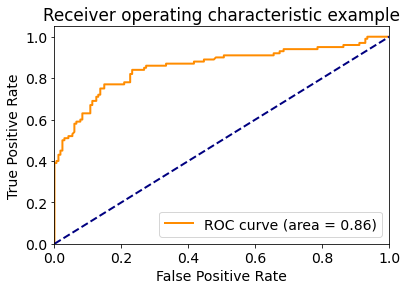

In [275]:
predicted_y = model.predict(X_test)
predicted_y_prob = model.predict_proba(X_test)[:,1]


[fpr, tpr, thr] = roc_curve(y_test, predicted_y_prob)
roc_auc = auc(fpr, tpr)

lw = 2
plt.plot(fpr, tpr, color = 'darkorange',
         lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

.score() takes the input and output as arguments and returns the ratio of the number of correct predictions to the number of observations.

In [276]:
model.score(X_test, y_test)

0.8134328358208955

We can get a more comprehensive report on the classification with classification_report():

In [277]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       168
           1       0.75      0.75      0.75       100

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268



In [278]:
print(" accuracy is %2.9f" % accuracy_score(y_test, predicted_y))
print(" log_loss is %2.9f" % log_loss(y_test, predicted_y_prob))
print(" auc is %2.9f" % auc(fpr, tpr))

 accuracy is 0.813432836
 log_loss is 0.431857532
 auc is 0.855833333


True: [0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0]
False: [0 0 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 1]


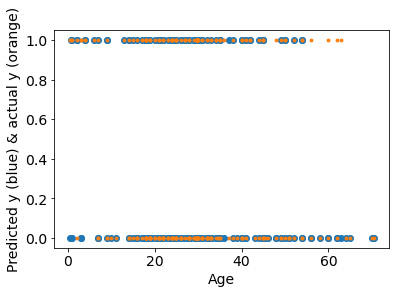

In [279]:
ax = plt.axes()
ax.scatter(X_test['Age'], predicted_y)
ax.scatter(X_test["Age"], y_test, s = 8)
plt.xlabel("Age")
plt.ylabel("Predicted y (blue) & actual y (orange)")

print('True:', y_test.values[0:25])
print('False:', predicted_y[0:25])

# for i in range(len(y_test)):
#     if (y_test.values[i] != predicted_y[i]):
#      print (i)
# print("len", len(y_test))
    

In [208]:
# ax = plt.axes()
# X = train.drop('Survived', axis=1)
# y = train['Survived']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
# # X_train = X_train.drop('Age', axis=1)
# # X_test = X_test.drop('Age', axis=1)
# index_values=range(0,len(y_test))
# y_test.sort_index(inplace=True)
# X_test.sort_index(inplace=True)
# model = LogisticRegression(solver='liblinear', C = 0.10001,  random_state= 0 ) 
# model.fit(X_train, y_train)
# modelPred_test = model.predict(X_test)
# ax.scatter(X_test["Age"], y_test.values)
# ax.scatter(X_test["Age"], modelPred_test)

# print(y_test.values, modelPred_test)

to get the optimum C ( or any other parameter used in the model) we use GridSearchCV:

In [268]:

# LogLoss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)
selected_Features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked", "CabinBool","NameTitle"]
X = train_data[selected_Features]
Y = train_data['Survived']
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gsCV = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')
gsCV.fit(X, Y)
results = gsCV.cv_results_
print(gsCV.best_score_, gsCV.best_estimator_ , gsCV.best_params_)

# gsCV1 = GridSearchCV(LogisticRegression(), return_train_score=True,
#                   param_grid=param_grid, scoring=scoring, cv=10, refit='AUC')
# gsCV1.fit(X, Y)
# results1 = gsCV1.cv_results_
# print(gsCV1.best_score_, gsCV1.best_estimator_ , gsCV1.best_params_)

# gsCV2 = GridSearchCV(LogisticRegression(), return_train_score=True,
#                   param_grid=param_grid, scoring=scoring, cv=10, refit='Log_Loss')

# gsCV2.fit(X, Y)
# results2 = gsCV2.cv_results_

# # print(gsCV2.best_score_, gsCV2.best_estimator_ , gsCV2.best_params_)

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

0.800187265917603 LogisticRegression(C=1.1000100000000002) {'C': 1.1000100000000002}


c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\python38-32\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_

In [210]:
# plt.scatter(X_test.iloc[:, 1], y_test, c = 'b')
# plt.scatter(X_test.iloc[:,1], predictions, c = 'r')
# plt.xlabel("True Values")
# plt.ylabel("Predictions")
# plt.scatter(y_test, predictions)

In [280]:
gbk = GradientBoostingClassifier()
gbk.fit(X_train, y_train)
y_pred = gbk.predict(X_test)
acc_gbk = round(accuracy_score(y_pred, y_test) * 100, 2)
print(acc_gbk)

84.7


In [283]:
test_data['Survived'] = model.predict(test_data[selected_Features])
test_data['PassengerId'] = test['PassengerId']

submission = test_data[['PassengerId','Survived']]

submission.to_csv("submission.csv", index=False)

submission.tail()


,PassengerId,Survived
413,1305,0
414,1306,1
415,1307,0
416,1308,0
417,1309,0
